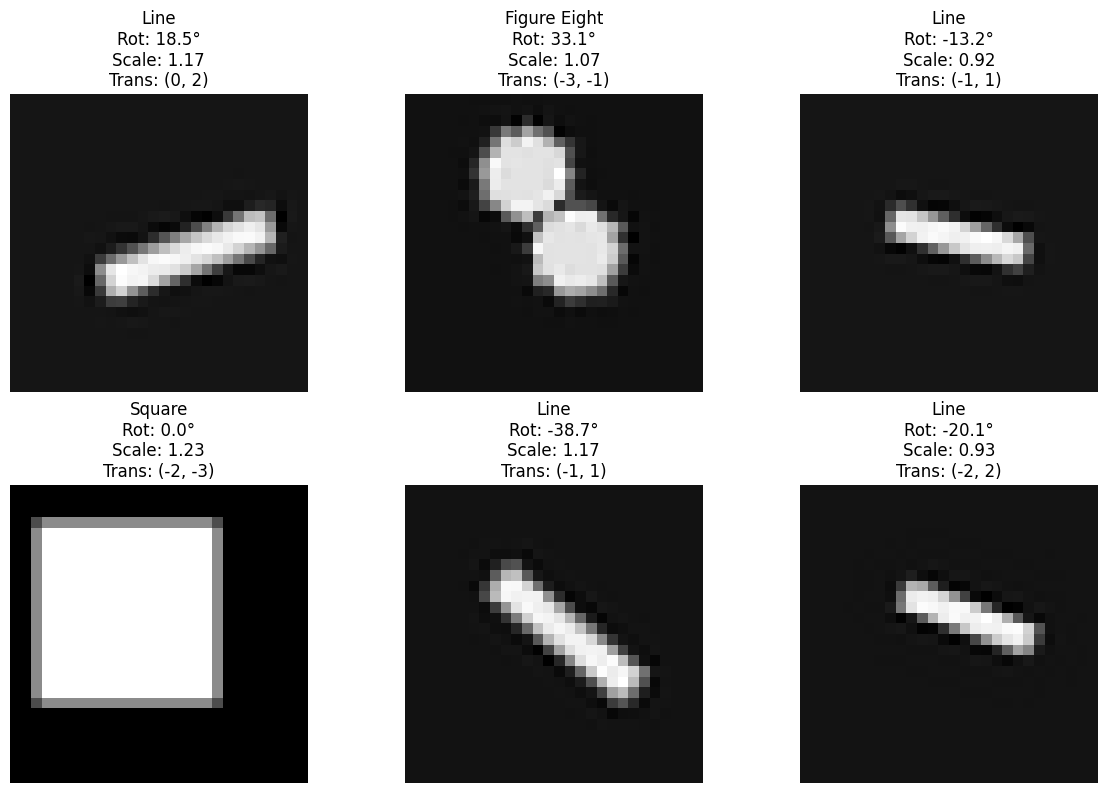

In [2]:
import copy

from torch.utils.data import DataLoader

from learnitation.shape_classifier import ShapeClassifier
from learnitation.shape_dataset import create_shape_dataset
from learnitation.trainer import (
    perform_model_pca,
    pure_test,
    train_model,
)

In [25]:
# Create datasets
train_dataset, test_dataset, _, _ = create_shape_dataset(
    num_samples=10000,
    rotation_range=(-45, 45),
    scale_range=(0.7, 1.3),
    translation_range=(-3, 3),
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Create and train model with snapshot saving enabled
model = ShapeClassifier()
history = train_model(
    model,
    train_loader,
    test_loader,
    num_epochs=15,
    save_last_snapshots=True,  # Enable snapshot saving
)


Epoch 1/15:
Train Loss: 0.8660, Train Accuracy: 61.17%
Test Loss: 0.5643, Test Accuracy: 72.15%
--------------------
Epoch 2/15:
Train Loss: 0.5602, Train Accuracy: 72.95%
Test Loss: 0.4763, Test Accuracy: 76.95%
--------------------
Epoch 3/15:
Train Loss: 0.4546, Train Accuracy: 79.05%
Test Loss: 0.2727, Test Accuracy: 88.65%
--------------------
Epoch 4/15:
Train Loss: 0.2211, Train Accuracy: 91.17%
Test Loss: 0.0622, Test Accuracy: 99.10%
--------------------
Epoch 5/15:
Train Loss: 0.0889, Train Accuracy: 97.01%
Test Loss: 0.0187, Test Accuracy: 99.45%
--------------------
Epoch 6/15:
Train Loss: 0.0418, Train Accuracy: 98.67%
Test Loss: 0.0251, Test Accuracy: 99.55%
--------------------
Epoch 7/15:
Train Loss: 0.0273, Train Accuracy: 99.12%
Test Loss: 0.0050, Test Accuracy: 99.80%
--------------------
Epoch 8/15:
Train Loss: 0.0241, Train Accuracy: 99.25%
Test Loss: 0.0040, Test Accuracy: 99.90%
--------------------
Epoch 9/15:
Train Loss: 0.0198, Train Accuracy: 99.29%
Test Loss


Number of model snapshots captured: 250

Explained variance ratios:
PC1: 0.6260
PC2: 0.2015
PC3: 0.0662

Explained variance ratios:
PC1: 0.6260
PC2: 0.2015
PC3: 0.0662

Cumulative explained variance:
First 1 components: 0.6260
First 2 components: 0.8275
First 3 components: 0.8937


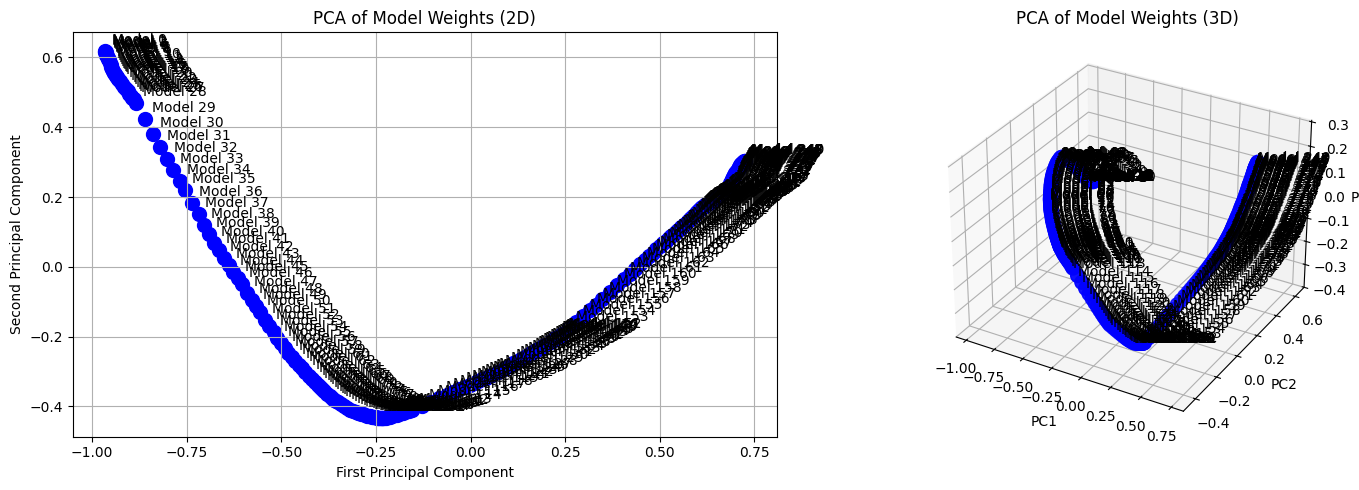

In [26]:
import numpy as np
import matplotlib.pyplot as plt

snapshots = history["model_snapshots"]
print(f"\nNumber of model snapshots captured: {len(snapshots)}")

# Perform PCA on the model snapshots
pca_results = perform_model_pca(snapshots)

# Print explained variance ratios
print("\nExplained variance ratios:")
for i, ratio in enumerate(pca_results[0].explained_variance_ratio_):
    print(f"PC{i+1}: {ratio:.4f}")

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca_results[0].explained_variance_ratio_)
print("\nCumulative explained variance:")
for i, cum_var in enumerate(cumulative_variance):
    print(f"First {i+1} components: {cum_var:.4f}")

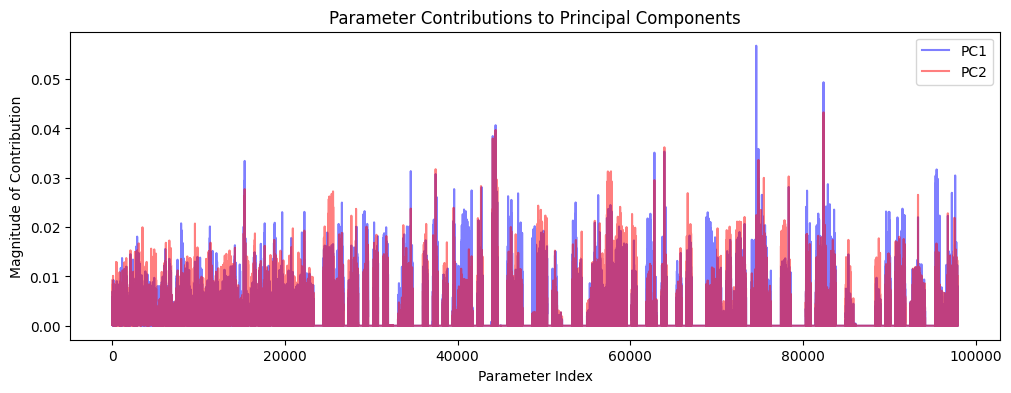

In [27]:
import numpy as np
# Get the components themselves
components = pca_results[0].components_

# Look at the magnitude of contributions from different parameters
plt.figure(figsize=(12, 4))
plt.plot(np.abs(components[0]), 'b-', alpha=0.5, label='PC1')
plt.plot(np.abs(components[1]), 'r-', alpha=0.5, label='PC2')
plt.title('Parameter Contributions to Principal Components')
plt.xlabel('Parameter Index')
plt.ylabel('Magnitude of Contribution')
plt.legend()
plt.show()

In [28]:
import torch
from learnitation.trainer import get_weight_vector, get_flattened_parameters
import torch.nn as nn
import random

def analyze_pc_perturbations(model, pca_results, test_loader, num_steps=10, perturbation_scale=1.0, downsample_fraction=1.0):
    """
    Analyze model behavior when perturbed along principal components
    """
    pca, transformed = pca_results
    device = next(model.parameters()).device
    
    # Get the original model's parameters as a vector (explicitly as float32)
    original_params = get_weight_vector(model).astype(np.float32)
    
    # Create a range of perturbation amounts
    alphas = np.linspace(-perturbation_scale, perturbation_scale, num_steps, dtype=np.float32)
    
    # Store results
    results = []
    current_subplot = 0
    fig = None
    axes = None
    
    # For each principal component
    for pc_idx in range(len(pca.components_)):
        if random.random() > downsample_fraction:
            continue
        # Create new figure every 36 components
        if current_subplot % 36 == 0:
            if fig is not None:
                plt.tight_layout()
                plt.show()
            fig, axes = plt.subplots(6, 6, figsize=(20, 20))
            axes = axes.ravel()
            current_subplot = 0
            
        pc_direction = pca.components_[pc_idx].astype(np.float32)
        pc_losses = []
        
        # For each perturbation amount
        for alpha in alphas:
            perturbed_params = original_params + alpha * pc_direction
            perturbed_model = copy.deepcopy(model)
            
            # Update the model parameters
            start_idx = 0
            for param in perturbed_model.parameters():
                num_params = param.numel()
                param.data = torch.tensor(
                    perturbed_params[start_idx:start_idx + num_params],
                    dtype=torch.float32
                ).reshape(param.shape).to(device)
                start_idx += num_params
            
            perturbed_model.eval()
            test_loss = 0
            criterion = nn.NLLLoss()
            
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)
                    output = perturbed_model(data)
                    test_loss += criterion(output, target).item()
            
            test_loss = test_loss / len(test_loader)
            pc_losses.append(test_loss)
        
        # Calculate slope at α=0 using central difference
        center_idx = len(alphas) // 2
        delta_alpha = alphas[center_idx + 1] - alphas[center_idx]
        slope_at_zero = (pc_losses[center_idx + 1] - pc_losses[center_idx - 1]) / (2 * delta_alpha)
        
        results.append({
            'pc_idx': pc_idx,
            'alphas': alphas,
            'losses': pc_losses,
            'slope_at_zero': slope_at_zero
        })
        
        # Plot in current subplot
        ax = axes[current_subplot]
        ax.plot(alphas, pc_losses, 'b-')
        ax.axvline(x=0, color='r', linestyle='--', alpha=0.5)
        ax.set_title(f'PC{pc_idx+1}\nSlope@0: {slope_at_zero:.2e}')
        if current_subplot % 6 == 0:  # leftmost plots
            ax.set_ylabel('Test Loss')
        if current_subplot >= 30:  # bottom plots
            ax.set_xlabel('α')
        ax.grid(True)
        
        current_subplot += 1
    
    # Show final figure if there are any remaining subplots
    if fig is not None:
        plt.tight_layout()
        plt.show()
    
    return results


Explained variance ratios:
PC1: 0.6260
PC2: 0.2015
PC3: 0.0662
PC4: 0.0339
PC5: 0.0266
PC6: 0.0138
PC7: 0.0089
PC8: 0.0070
PC9: 0.0047
PC10: 0.0026
PC11: 0.0017
PC12: 0.0017
PC13: 0.0011
PC14: 0.0010
PC15: 0.0007
PC16: 0.0006
PC17: 0.0004
PC18: 0.0003
PC19: 0.0002
PC20: 0.0002
PC21: 0.0002
PC22: 0.0001
PC23: 0.0001
PC24: 0.0001
PC25: 0.0001
PC26: 0.0001
PC27: 0.0000
PC28: 0.0000
PC29: 0.0000
PC30: 0.0000
PC31: 0.0000
PC32: 0.0000
PC33: 0.0000
PC34: 0.0000
PC35: 0.0000
PC36: 0.0000


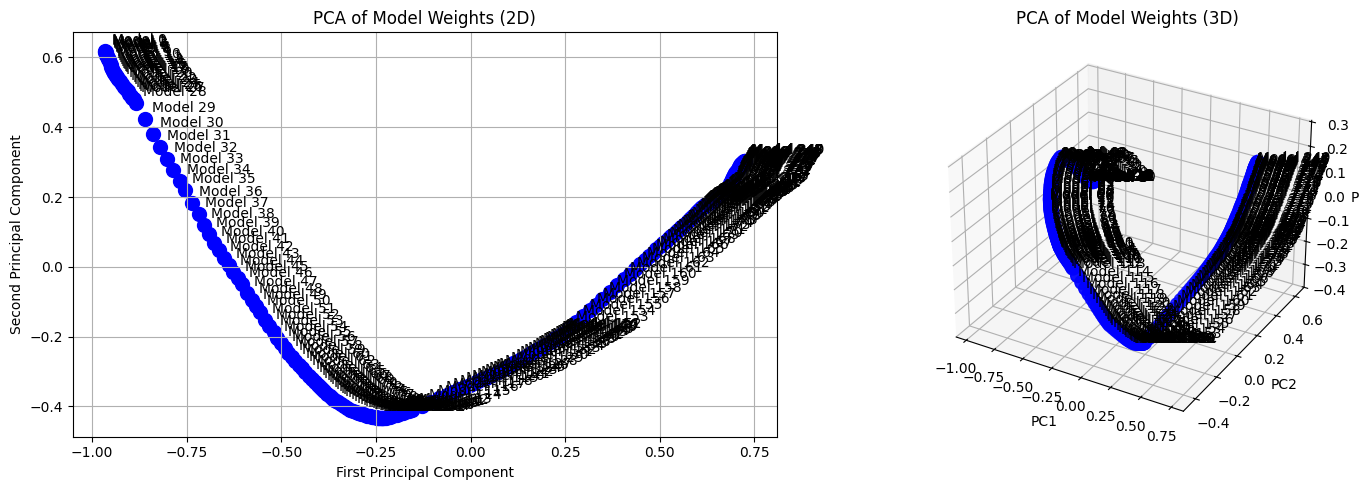

In [29]:
# Get the final model snapshot
final_model = snapshots[-1]

# Perform PCA on all snapshots
pca_results = perform_model_pca(snapshots, n_components=36) # 1_000)

# Analyze perturbations along principal components
# perturbation_results = analyze_pc_perturbations(
#    final_model,
#    pca_results,
#    test_loader,
#    num_steps=20,
#    perturbation_scale=2.0,
#    # downsample_fraction=0.1,
#)

In [30]:
# create models
model_no_square_rotate = ShapeClassifier()

# Create datasets

# do not rotate the square
no_rotate_square = {i: False for i in range(6)}
no_rotate_square[1] = {"rotation": True, "scale": False, "translation": False}
train_dataset_no_square_rotate, test_dataset_no_square_rotate, _, _ = create_shape_dataset(
    num_samples=10000,
    rotation_range=(-45, 45),
    scale_range=(0.7, 1.3),
    translation_range=(-3, 3),
    turn_off_morphism_for_shape=no_rotate_square
)

# Create data loaders
train_loader_no_square_rotate = DataLoader(train_dataset_no_square_rotate, batch_size=32, shuffle=True)
test_loader_no_square_rotate = DataLoader(test_dataset_no_square_rotate, batch_size=32)

# Train model
history_no_square_rotate = train_model(
    model_no_square_rotate, 
    train_loader_no_square_rotate, 
    test_loader_no_square_rotate, 
    num_epochs = 15,
    save_last_snapshots=True
)
model_no_sq_og = copy.deepcopy(model_no_square_rotate)

Epoch 1/15:
Train Loss: 0.8302, Train Accuracy: 64.58%
Test Loss: 0.3330, Test Accuracy: 87.00%
--------------------
Epoch 2/15:
Train Loss: 0.2675, Train Accuracy: 88.67%
Test Loss: 0.1874, Test Accuracy: 91.05%
--------------------
Epoch 3/15:
Train Loss: 0.1665, Train Accuracy: 92.96%
Test Loss: 0.1122, Test Accuracy: 96.55%
--------------------
Epoch 4/15:
Train Loss: 0.0937, Train Accuracy: 96.65%
Test Loss: 0.0290, Test Accuracy: 99.70%
--------------------
Epoch 5/15:
Train Loss: 0.0536, Train Accuracy: 98.24%
Test Loss: 0.0083, Test Accuracy: 100.00%
--------------------
Epoch 6/15:
Train Loss: 0.0333, Train Accuracy: 98.92%
Test Loss: 0.0074, Test Accuracy: 99.85%
--------------------
Epoch 7/15:
Train Loss: 0.0200, Train Accuracy: 99.47%
Test Loss: 0.0009, Test Accuracy: 100.00%
--------------------
Epoch 8/15:
Train Loss: 0.0193, Train Accuracy: 99.46%
Test Loss: 0.0012, Test Accuracy: 100.00%
--------------------
Epoch 9/15:
Train Loss: 0.0228, Train Accuracy: 99.35%
Test L


Explained variance ratios:
PC1: 0.5966
PC2: 0.1718
PC3: 0.1279
PC4: 0.0348
PC5: 0.0255
PC6: 0.0125
PC7: 0.0103
PC8: 0.0057
PC9: 0.0044
PC10: 0.0036
PC11: 0.0017
PC12: 0.0017
PC13: 0.0009
PC14: 0.0008
PC15: 0.0005
PC16: 0.0004
PC17: 0.0002
PC18: 0.0002
PC19: 0.0001
PC20: 0.0001
PC21: 0.0001
PC22: 0.0001
PC23: 0.0000
PC24: 0.0000
PC25: 0.0000
PC26: 0.0000
PC27: 0.0000
PC28: 0.0000
PC29: 0.0000
PC30: 0.0000
PC31: 0.0000
PC32: 0.0000
PC33: 0.0000
PC34: 0.0000
PC35: 0.0000
PC36: 0.0000
PC37: 0.0000
PC38: 0.0000
PC39: 0.0000
PC40: 0.0000
PC41: 0.0000
PC42: 0.0000
PC43: 0.0000
PC44: 0.0000
PC45: 0.0000
PC46: 0.0000
PC47: 0.0000
PC48: 0.0000
PC49: 0.0000
PC50: 0.0000
PC51: 0.0000
PC52: 0.0000
PC53: 0.0000
PC54: 0.0000
PC55: 0.0000
PC56: 0.0000
PC57: 0.0000
PC58: 0.0000
PC59: 0.0000
PC60: 0.0000
PC61: 0.0000
PC62: 0.0000
PC63: 0.0000
PC64: 0.0000
PC65: 0.0000
PC66: 0.0000
PC67: 0.0000
PC68: 0.0000
PC69: 0.0000
PC70: 0.0000
PC71: 0.0000
PC72: 0.0000
PC73: 0.0000
PC74: 0.0000
PC75: 0.0000
PC76: 

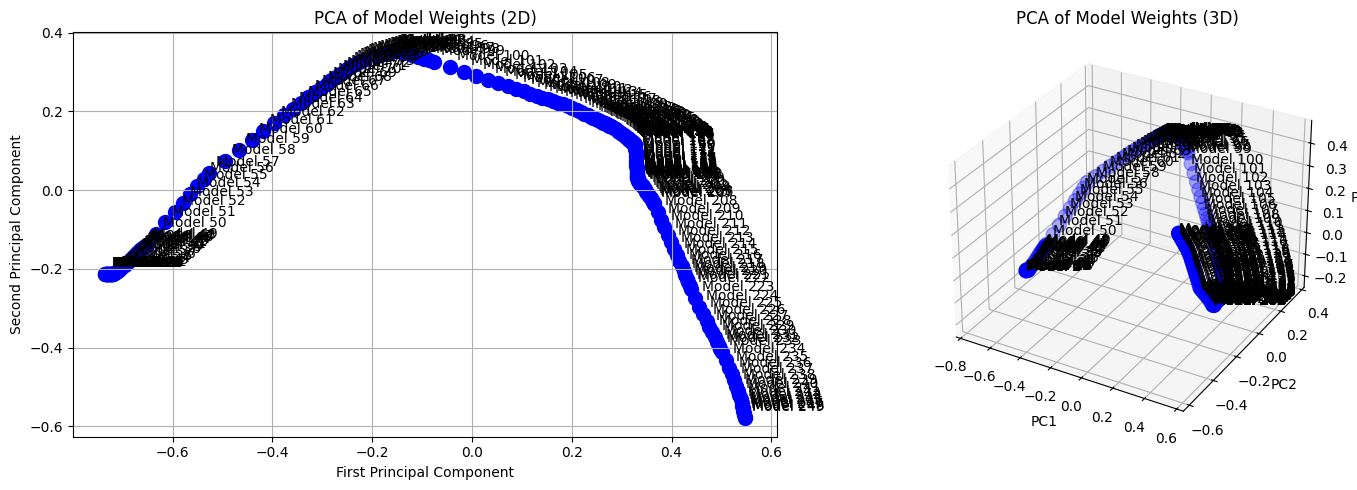

In [31]:
snapshots_no_square_rotate = history_no_square_rotate["model_snapshots"]
pca_results = perform_model_pca(snapshots_no_square_rotate, n_components=250)

In [39]:
pure_test(model_no_sq_og, test_loader_no_square_rotate)
pure_test(model_no_sq_og, test_loader)

Test Loss: 0.0011, Test Accuracy: 99.95%
Test Loss: 3.3585, Test Accuracy: 88.95%


In [33]:
# Train model on complete dataset
history_no_square_rotate_one_epoch_full = train_model(model_no_square_rotate, 
    train_loader, 
    test_loader, 
    num_epochs = 1,
    save_last_snapshots=True,
)
model_no_sq_fulldata = copy.deepcopy(model_no_square_rotate)

Epoch 1/1:
Train Loss: 0.1902, Train Accuracy: 94.98%
Test Loss: 0.0154, Test Accuracy: 99.70%
--------------------


In [34]:
pure_test(model_no_sq_fulldata, test_loader_no_square_rotate)
pure_test(model_no_sq_fulldata, test_loader)

Test Loss: 0.0049, Test Accuracy: 100.00%
Test Loss: 0.0154, Test Accuracy: 99.70%


In [35]:
complete_snapshots = history_no_square_rotate_one_epoch_full["model_snapshots"]
weight_vectors = np.array([get_weight_vector(model) for model in complete_snapshots])
# Perform PCA
pca = pca_results[0]
transformed = pca.transform(weight_vectors)

In [36]:
# Retrain on OG dataset again
history_no_square_rotate_one_epoch_full_one_epoch_no_rotate = train_model(
    model_no_square_rotate, 
    train_loader, 
    test_loader, 
    num_epochs = 1,
    save_last_snapshots=True,
)
model_no_sq_go_back_to_og = copy.deepcopy(model_no_square_rotate)

Epoch 1/1:
Train Loss: 0.0395, Train Accuracy: 98.62%
Test Loss: 0.0242, Test Accuracy: 99.15%
--------------------


In [37]:
pure_test(model_no_sq_go_back_to_og, test_loader_no_square_rotate)
pure_test(model_no_sq_go_back_to_og, test_loader)

Test Loss: 0.0414, Test Accuracy: 98.40%
Test Loss: 0.0242, Test Accuracy: 99.15%


In [40]:
complete_snapshots = history_no_square_rotate_one_epoch_full_one_epoch_no_rotate["model_snapshots"]
weight_vectors = np.array([get_weight_vector(model) for model in complete_snapshots])
# Perform PCA
pca = pca_results[0]
transformed_after = pca.transform(weight_vectors)

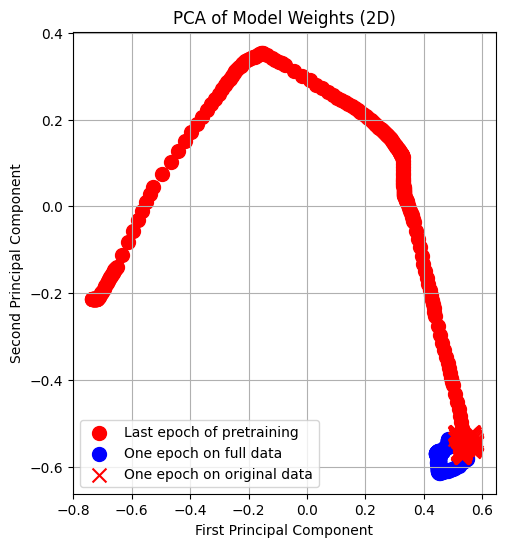

In [41]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax1.scatter(pca_results[1][:, 0], pca_results[1][:, 1], c="red", marker="o", s=100)
ax1.scatter(transformed[:, 0], transformed[:, 1], c="blue", marker="o", s=100)
ax1.scatter(transformed_after[:, 0], transformed_after[:, 1], c="red", marker="x", s=100)
ax1.set_xlabel("First Principal Component")
ax1.set_ylabel("Second Principal Component")
ax1.set_title("PCA of Model Weights (2D)")
ax1.legend(["Last epoch of pretraining", "One epoch on full data", "One epoch on original data"])
ax1.grid(True)

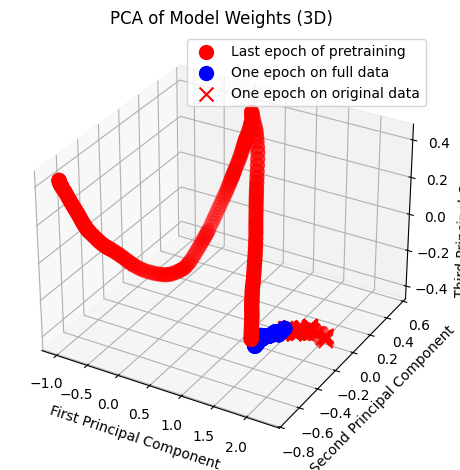

In [15]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(pca_results[1][:, 0], pca_results[1][:, 1], pca_results[1][:, 2], c="red", marker="o", s=100)
ax1.scatter(transformed[:, 0], transformed[:, 1], transformed[:, 2], c="blue", marker="o", s=100)
ax1.scatter(transformed_after[:, 0], transformed_after[:, 1], transformed_after[:, 2], c="red", marker="x", s=100)
ax1.set_xlabel("First Principal Component")
ax1.set_ylabel("Second Principal Component") 
ax1.set_zlabel("Third Principal Component")
ax1.set_title("PCA of Model Weights (3D)")
ax1.legend(["Last epoch of pretraining", "One epoch on full data", "One epoch on original data"])
ax1.grid(True)